Here I make some tests to check that the new functions work.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __future__ import print_function

import time
import pprint

from phyton_optics import degrees, plt
from math import pi, sqrt, sin, cos, tan
from sympy.functions.special.tensor_functions import Eijk

import polarimeter.polarimeter as opsys
import phyton_optics.polarization_jones as pj
import phyton_optics.polarization_stokes as ps
import phyton_optics.polarization_mueller_analysis as amm
import phyton_optics.utils_common as mt

import numpy as np
import scipy as sp
import os

# Just tests
from sympy.physics.paulialgebra import Pauli

AttributeError: 'module' object has no attribute 'polarization_stokes'

## All parameters check

First, use a random matrixx that will violate almost all of the conditions.

In [3]:
M = np.random.rand(4,4)
#print(M)
info = amm.all_parameters(M, output=True, verbose=True)
#print(info)

 
Parameters of the matrix:
  The matrix is not physically consistent:
    - Second condition violated (distance = -0.2962514171)
    - Third condition violated (distance = -1.1192980375)
    - Fifth condition violated (distance = -0.945314195219)
    - Sixth condition violated (distance = -0.431001071221)
  The matrix is pure.
    - The matrix is homogenous.
    # The matrix is not a pure retarder.
      -> First condition violated: 0.335072167604
      -> Second condition violated: 0.613338171358
      -> Third condition violated: 5.43223978823
    # The matrix is not a pure diattenuator.
      -> Deviation: 0.344834324009
  The matrix is not singular.
    - The determinant of the matrix is = 0.0237758564342
    - The minimum eigenvalue of the matrix is = 0.0392593308924
  The mean intensity coefficient (m00) is: 0.684966286468
  The diattenuation is: 1.84001451407
    - The linear diattenuation is: 1.43987281195
    - The circular diattenuation is: 1.14560887628
  The polarizance is

Now, repeat it with physical realizable matrices to check that works with real matrices.

In [5]:
p1 = 0.95
p2 = 0.5
ret = pi/2
delta = pi/4
alpha = pi/8
D = np.array([0.22273864, 0.22162587, 0.01222959])/0.325
m00 = 0.325

M = ps.general_diattenuator_param(p1, p2, alpha, delta, True)
M = ps.general_retarder_param(ret, alpha, delta, True)
#M = np.diag((1,0.2,0.3,0.4))+
#print(M/M[0,0])
print(M)
P = amm.polarizance(M)
D = amm.diattenuation(M)
PS = amm.spheric_purity(M)
#print([P, D, PS, sqrt((P**2+D**2)/3+PS**2)])
Pi = amm.polarimetric_purity_indices(M)
#print(Pi)
#print(sqrt(2*Pi[0]**2 + 2/3*Pi[1]**2 + 1/3*Pi[2]**2))
#D = ps.calculate_delay(M)
#R = ps.calculate_retardance(M)
#print([D, R])
#M2 = ps.general_retarder_vect(D, R, .9)
#print(M2)
info = amm.all_parameters(M, output=True, verbose=True)

[[ 1.          0.          0.          0.        ]
 [ 0.          0.5         0.85355339 -0.14644661]
 [ 0.         -0.14644661  0.25        0.95710678]
 [ 0.          0.85355339 -0.45710678  0.25      ]]
 
Parameters of the matrix:
  The matrix is physically consistent.
  The matrix is pure.
    - The matrix is homogenous.
    # The matrix is a pure retarder.
      - Delay = 90.0.
      - Angle = 44.9999993963; Delay between components = 89.9999987926.
      - Azimuth = 22.5; Ellipticity = 44.9999991462.
    # The matrix is not a pure diattenuator.
      -> Deviation: 0.426776695297
  The matrix is not singular.
    - The determinant of the matrix is = 1.0
    - The minimum eigenvalue of the matrix is = 1.0
  The mean intensity coefficient (m00) is: 1.0
  The diattenuation is: 0.0
    - The linear diattenuation is: 0.0
    - The circular diattenuation is: 0.0
  The polarizance is: 0.0
    - The linear polarizance is: 0.0
    - The circular polarizance is: 0.0
  The polarizance degree 

Check of the calculation of the covariant matrix.

In [6]:
M = np.matrix(np.array([[1, -0.0229, 0.0027, 0.0058],
                 [-0.0186, 0.9956, -0.0361, 0.0318],
                 [-0.0129, 0.0392, 0.2207, -0.9656],
                 [0.0014, 0.0280, 0.9706, 0.2231]]))
print(M)
H = amm.covariance_matrix(M)
print(H)
l, _ = np.linalg.eig(H)
print(l)

[[ 1.     -0.0229  0.0027  0.0058]
 [-0.0186  0.9956 -0.0361  0.0318]
 [-0.0129  0.0392  0.2207 -0.9656]
 [ 0.0014  0.028   0.9706  0.2231]]
[[ 0.488525+0.j      -0.00835 +0.0094j   0.006575-0.00735j
   0.11095 -0.48405j]
 [-0.00835 -0.0094j   0.002175+0.j      -0.0006  -0.00125j
  -0.013025+0.00665j]
 [ 0.006575+0.00735j -0.0006  +0.00125j  0.000025+0.j
   0.0097  -0.0065j ]
 [ 0.11095 +0.48405j -0.013025-0.00665j  0.0097  +0.0065j
   0.509275+0.j     ]]
[ 0.99621686-0.j  0.00402577-0.j  0.00080316-0.j -0.0010458 +0.j]


Check the change of coordinates between characteristic angles and azimuth / elipticity.

In [49]:
delta = 2*pi*(np.random.rand(1))
alpha = 0.5*pi*(np.random.rand(1))
#alpha = pi/4
#delta = 3*pi/2
print([alpha/degrees, delta/degrees])

fi, chi = pj.carac_angles_2_azimuth_elipt(alpha, delta)
print([fi/degrees, chi/degrees])

alpha, delta = pj.azimuth_elipt_2_carac_angles(fi, chi)
print([alpha/degrees, delta/degrees])

[array([2.91132115]), array([133.89081035])]
[array([177.97800831]), array([2.09634038])]
[array([2.91132115]), array([133.89081035])]


In [65]:
fi = pi*(np.random.rand(1))
chi= pi/2*(0.5-np.random.rand(1))
fi=0
chi=pi/4
print([fi/degrees, chi/degrees])

alpha, delta = pj.azimuth_elipt_2_carac_angles(fi, chi)
print([alpha/degrees, delta/degrees])

fi, chi = pj.carac_angles_2_azimuth_elipt(alpha, delta)
print([fi/degrees, chi/degrees])

[0.0, 45.0]
[45.0, 180.0]
[135.0, 3.508354649267438e-15]


Check the functions to create and read pure elements.

In [103]:
p1 = 0.9
p2 = 0.2
p1 = np.random.rand(1)[0]
p2 = np.random.rand(1)[0]
delta = 2*pi*(np.random.rand(1)[0])
alpha = 0.5*pi*(np.random.rand(1)[0])
#alpha = pi/4+.1
#delta = pi/2+.1
fi, chi = pj.carac_angles_2_azimuth_elipt(alpha, delta)
print(["Parametros diat:", p1, p2, alpha/degrees, delta/degrees, fi/degrees, chi/degrees])

f = (p1**2 - p2**2) / (p1**2 + p2**2)
#print([f, np.linalg.norm(D)])
D = f * np.array([cos(2 * alpha), sin(2 * alpha) * cos(delta), f * sin(2 * alpha) * sin(delta) ])
#print(D)

M = ps.general_diattenuator_parvect(p1, p2, alpha, delta, True)
#print(M)
p1, p2, alphaD, deltaD, chiD, fiD = amm.parameters_diattenuator(M)
print(["Medidas diat:", p1, p2, alphaD/degrees, deltaD/degrees, chiD/degrees, fiD/degrees])



['Parametros diat:', 0.5925387970859174, 0.09177541747252704, 43.784184699382074, 345.85323024038945, 43.74620706495952, -7.066883242839947]
['Medidas diat:', 0.5925387970859174, 0.091775417472527, 43.784184699382074, 345.8532302403894, 43.74620706495952, -7.066883242839973]


In [107]:
p1 = 1
p2 = 0.
fi = pi*(np.random.rand(1)[0])
chi = 0.5*pi*(0.5-np.random.rand(1)[0])
#fi = 0.00
#chi = pi/4
alpha, delta = pj.azimuth_elipt_2_carac_angles(fi, chi)
print(["Parametros introducidos diat:", p1, p2, alpha/degrees, delta/degrees, fi/degrees, chi/degrees])

#M = ps.general_diattenuator_param(p1, p2, alpha, delta, True)
M = ps.general_diattenuator_param(p1, p2, fi, chi, False)
print(M)
p1, p2, alphaD, deltaD, fiD, chiD = amm.parameters_diattenuator(M)
print(["Parametros medidos diat:", p1, p2, alphaD/degrees, deltaD/degrees, fiD/degrees, chiD/degrees])


['Parametros introducidos diat:', 1, 0.0, 30.070688397739186, 139.37854938150542, 153.55040525551195, 17.188462760608964]
[2.6799601394802886, 0.29999526852906033]
[0.524832520881807, 2.4326145933607757]
[[ 0.5         0.24893079 -0.32913582  0.28231733]
 [ 0.24893079  0.12393307 -0.16386408  0.14055495]
 [-0.32913582 -0.16386408  0.21666078 -0.18584149]
 [ 0.28231733  0.14055495 -0.18584149  0.15940615]]
['Parametros medidos diat:', 1.0, 0.0, 30.070688397739186, 139.3785493815054, 153.55040525551195, 17.188462760608985]


Now, the retarder.

In [202]:
ret = pi*(np.random.rand(1)[0])
delta = 2*pi*(np.random.rand(1)[0])
alpha = 0.5*pi*(np.random.rand(1)[0])
ret = 25.853037059301432*degrees
alpha = 67.49234027796533*degrees
#alpha = 23.715303844748167*degrees
delta = 330.61683437632155*degrees
(cr, sr) = (cos(ret), sin(ret))
ur = [cos(2*alpha), sin(2*alpha)*cos(delta), sin(2*alpha)*sin(delta)]
mR = np.array([[1, 0, 0, 0],
    [0, cr+(1-cr)*ur[0]**2,  (1-cr)*ur[0]*ur[1]+sr*ur[2],  (1-cr)*ur[0]*ur[2]-sr*ur[1]],
    [0, (1-cr)*ur[0]*ur[1]-sr*ur[2],  cr+(1-cr)*ur[1]**2, (1-cr)*ur[1]*ur[2]+sr*ur[0]],
    [0, (1-cr)*ur[0]*ur[2]+sr*ur[1],  (1-cr)*ur[1]*ur[2]-sr*ur[0],   cr+(1-cr)*ur[2]**2]])

fi, chi = pj.carac_angles_2_azimuth_elipt(alpha, delta)
print(["Parametros introducidos ret:", ret/degrees, alpha/degrees, delta/degrees, fi/degrees, chi/degrees])
#print(["Parametros introducidos ret:", ret, alpha, delta, fi, chi])
print(ur)

#M = ps.general_retarder_param(ret, alpha, delta, True)
M = ps.general_retarder_parvect(ret, alpha, delta, True)
#print(M)
#print(mR)
#print(abs(M-mR).max())
#M = ps.general_retarder_param(ret, fi, chi, False)
R, alphaD, deltaD, fiD, chiD = amm.parameters_retarder(M)
print(["Parametros medidos ret:", R/degrees, alphaD/degrees, deltaD/degrees, fiD/degrees, chiD/degrees])
#print(["Parametros medidos ret:", R, alphaD, deltaD, fiD, chiD])



['Parametros introducidos ret:', 25.853037059301432, 67.49234027796533, 330.61683437632155, 69.4586488321522, -10.15297682456568]
[-0.7069176934227618, 0.6163078757724523, -0.34703310647067914]
['Parametros medidos ret:', 25.85303705930143, 67.49234027796533, 330.61683437632155, 69.4586488321522, -10.152976824565679]


Finally, check that any value takes very low error.

[7.052084610714715e-15, 5.8309228556652215e-09]


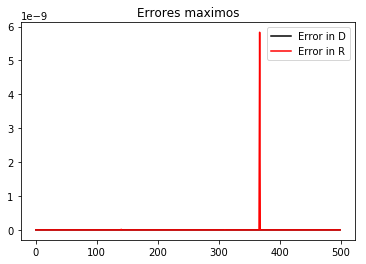

In [216]:
def max_error(x, y):
    z = abs(x-y)
    return z.max()

N = 500
maxErrorD = np.zeros(N)
maxErrorR = np.zeros(N)
for ind in range(N):
    # Generate random parameters
    ret = pi*(np.random.rand(1)[0])
    delta = 2*pi*(np.random.rand(1)[0])
    alpha = 0.5*pi*(np.random.rand(1)[0])
    fi, chi = pj.carac_angles_2_azimuth_elipt(alpha, delta)
    p1 = 0.5 + 0.5*np.random.rand(1)[0]
    p2 = 0.5*np.random.rand(1)[0]
    # Create elements
    Mr = ps.general_retarder_parvect(ret, alpha, delta, True)
    Md = ps.general_diattenuator_parvect(p1, p2, alpha, delta, True)
    # Read values
    p1, p2, alphaD, deltaD, fiD, chiD = amm.parameters_diattenuator(Md)
    R, alphaR, deltaR, fiR, chiR = amm.parameters_retarder(Mr)
    # Check error
    paramD = np.array([p1, p2, alpha, delta, fi, chi])
    eD = np.array([p1, p2, alphaD, deltaD, fiD, chiD])
    paramR = np.array([ret, alpha, delta, fi, chi])
    eR = np.array([R, alphaR, deltaR, fiR, chiR])
    #print(paramD)
    #print(eD)
    maxErrorD[ind] = max_error(paramD, eD)
    maxErrorR[ind] = max_error(paramR, eR)
# Print result
print([maxErrorD.max(), maxErrorR.max()])
plt.figure()
plt.plot(range(N), maxErrorD,'k', label='Error in D')
plt.hold = True
plt.title('Errores maximos')
plt.plot(range(N), maxErrorR,'r', label='Error in R')
plt.legend()




It works fine!!!! Now we can try to decompose a matrix.

## Polar decomposition of pure matrices

In [246]:
# Parameters
ret = pi*(np.random.rand(1)[0])
deltaR = 2*pi*(np.random.rand(1)[0])
alphaR = 0.5*pi*(np.random.rand(1)[0])
fiR, chiR = pj.carac_angles_2_azimuth_elipt(alphaR, deltaR)
delta = 2*pi*(np.random.rand(1)[0])
alpha = 0.5*pi*(np.random.rand(1)[0])
fi, chi = pj.carac_angles_2_azimuth_elipt(alpha, delta)
p1 = 0.5 + 0.5*np.random.rand(1)[0]
p2 = 0.5*np.random.rand(1)[0]
print('Parametros iniciales del retardador:')
param = np.array([ret/degrees, alphaR/degrees, deltaR/degrees, fiR/degrees, chiR/degrees])
print(param)

# Create elements
Mr = ps.general_retarder_parvect(ret, alphaR, deltaR, True)
Md = ps.general_diattenuator_parvect(p1, p2, alpha, delta, True)
M = Mr*Md

R, alphaR2, deltaR2, fiR2, chiR2 = amm.parameters_retarder(Mr)
print('Parametros medidos directamente del retardador:')
param = np.array([R/degrees, alphaR2/degrees, deltaR2/degrees, fiR2/degrees, chiR2/degrees])
print(param)

#print(Mr)
#print(Md)
#print(M)
# Decompose
Mr, Md = amm.decompose_pure(M, right=True, verbose=True, co=False)
param = np.array([p1, p2, alpha/degrees, delta/degrees, fi/degrees, chi/degrees])
print('Parametros iniciales del diatenuador:')
print(param)

p1, p2, alphaD2, deltaD2, fiD2, chiD2 = amm.parameters_diattenuator(Md)
param = np.array([p1, p2, alphaD2/degrees, deltaD2/degrees, fiD2/degrees, chiD2/degrees])
print('Parametros medidos directamente del diatenuador:')
print(param)
print('Parametros medidos directamente de la matriz producto:')
p1, p2, alphaD2, deltaD2, fiD2, chiD2 = amm.parameters_diattenuator(M)
param = np.array([p1, p2, alphaD2/degrees, deltaD2/degrees, fiD2/degrees, chiD2/degrees])
print(param)

Parametros iniciales del retardador:
[ 5.69391887 49.52132186 30.78119516 50.24734125 15.17897338]
Parametros medidos directamente del retardador:
[ 5.69391887 49.52132186 30.78119516 50.24734125 15.17897338]
------------------------------------------------------
Matrx M decomposed as M = Mr * Md.

The retarder Mueller matrix is:
[[ 1.         -0.          0.         -0.        ]
 [-0.          0.99518798  0.04948494 -0.08457019]
 [-0.         -0.05080082  0.99861786 -0.01347775]
 [-0.          0.08378635  0.01770913  0.99632637]]
Parameters:
  - Delay = 5.69391886789.
  - Angle = 49.5213218624; Delay between components = 30.781195163.
  - Azimuth = 50.2473412522; Ellipticity = 15.1789733758.

The diatenuator Mueller matrix is:
[[ 0.2377802  -0.07295214  0.00584231  0.00681645]
 [-0.07295214  0.2272307  -0.00008779 -0.00010243]
 [ 0.00584231 -0.00008779  0.22614153  0.0000082 ]
 [ 0.00681645 -0.00010243  0.0000082   0.22614407]]
Parameters:
  - p1 = 0.557927109864; p2 = 0.405311906052.

It works perfectly fine.

## Polar decomposition of general matrices

In [411]:
# Parameters
ret = pi*(np.random.rand(1)[0])
deltaR = 2*pi*(np.random.rand(1)[0])
alphaR = 0.5*pi*(np.random.rand(1)[0])
fiR, chiR = pj.carac_angles_2_azimuth_elipt(alphaR, deltaR)
delta = 2*pi*(np.random.rand(1)[0])
alpha = 0.5*pi*(np.random.rand(1)[0])
fi, chi = pj.carac_angles_2_azimuth_elipt(alpha, delta)
p1 = 0.5 + 0.5*np.random.rand(1)[0]
p2 = 0.5*np.random.rand(1)[0]
Pvd = np.random.rand(3)
Pvd = Pvd / (5*np.linalg.norm(Pvd))
dv = np.flip(np.sort(np.random.rand(3)), 0)*.5
dv = [0.2001, 0.2, 0.1]
md = np.diag(dv)
cero = np.zeros(3)

# Create elements
Mr = ps.general_retarder_parvect(ret, alphaR, deltaR, True)
Mp = ps.general_diattenuator_parvect(p1, p2, alpha, delta, True)
Md = ps.create_from_blocks(cero, Pvd, md)
M = Md * (Mr * Mp)

# Info about matrices
#print(M)
print(Md)
print(Mr)
print(Mp)
#amm.all_parameters(Md)
#amm.all_parameters(M)
print(amm.is_singular2(Mp))
print(amm.is_real(Md))



[[1.         0.         0.         0.        ]
 [0.07744356 0.2001     0.         0.        ]
 [0.14697709 0.         0.2        0.        ]
 [0.11135632 0.         0.         0.1       ]]
[[ 1.          0.          0.          0.        ]
 [ 0.          0.89150192  0.13116532 -0.43361272]
 [ 0.          0.19848245  0.74731337  0.63413519]
 [ 0.          0.40722113 -0.65139725  0.64019729]]
[[ 0.23587998  0.16209774 -0.04082395 -0.028242  ]
 [ 0.16209774  0.22971778 -0.0165482  -0.01144804]
 [-0.04082395 -0.0165482   0.16817824  0.00288316]
 [-0.028242   -0.01144804  0.00288316  0.16600519]]
False
True


In [412]:
# Print initial parameters
print('Parametros iniciales del retardador:')
param = np.array([ret/degrees, alphaR/degrees, deltaR/degrees, fiR/degrees, chiR/degrees])
print(param)
print('Parametros iniciales del diatenuador:')
param1 = np.array([p1, p2, alpha/degrees, delta/degrees, fi/degrees, chi/degrees])
print(param1)
print('Parametros iniciales del despolarizador:')
pd = amm.polarizance(Md)
desp = amm.depolarization_index(Md)
isr = amm.is_real(Md)
param2 = [isr, pd, desp]
print(param2)

# Decompose
Md2, Mr2, Mp2 = amm.decompose_polar(M, decomposition='DRP', verbose=True, co=False)

# Print again initial parameters
print('Parametros iniciales del retardador:')
print(param)
print('Parametros iniciales del diatenuador:')
print(param1)
print('Parametros iniciales del despolarizador:')
print(param2)
print(M)
print(Md2*Mr2*Mp2)


Parametros iniciales del retardador:
[ 50.24498539  16.63578628 355.422665    16.59383565  -1.25464732]
Parametros iniciales del diatenuador:
[  0.63671689   0.25758798   8.51333304 214.67547574 172.93208053
  -4.79485082]
Parametros iniciales del despolarizador:
[True, 0.19999999999999996, 0.9780865656985582]
------------------------------------------------------
Polar decomposition of the matrix M = Mdesp * Mr * Mp:

The depolarizer Mueller matrix is:
[[1.         0.         0.         0.        ]
 [0.07744356 0.2001     0.         0.        ]
 [0.14697709 0.         0.2        0.        ]
 [0.11135632 0.         0.         0.1       ]]
Parameters:
  - Polarizance = 0.2.
  - Depolarization degree = 0.978086565699.

The retarder Mueller matrix is:
[[ 1.          0.          0.          0.        ]
 [ 0.          0.89150192  0.13116532 -0.43361272]
 [ 0.          0.19848245  0.74731337  0.63413519]
 [ 0.          0.40722113 -0.65139725  0.64019729]]
Parameters:
  - Delay = 50.244985386

It works perfectly fine while the eigenvalues of the m matrix of the depolarizer are different. If not, the result starts to be inaccurate.

In [338]:
a = [1, 3, 4, -6, 2, 5]
s = np.random.rand(3,6)
print(s)
a2, s2 = mt.order_eig(a, s)
print(a2)
print( s2 )

[[0.2228166  0.80141546 0.90432515 0.40574794 0.61802249 0.659618  ]
 [0.2627407  0.02279919 0.96445847 0.23188154 0.5416931  0.48430137]
 [0.14412073 0.7014205  0.10005075 0.67956801 0.48007611 0.57204851]]
[ 5  4  3  2  1 -6]
[[0.659618   0.90432515 0.80141546 0.61802249 0.2228166  0.40574794]
 [0.48430137 0.96445847 0.02279919 0.5416931  0.2627407  0.23188154]
 [0.57204851 0.10005075 0.7014205  0.48007611 0.14412073 0.67956801]]


In [386]:
np.finfo(np.longdouble).eps

2.220446049250313e-16